In [1]:
import numpy as np
import pandas as pd
import random
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *
from model import *
from config import Config
import sys
import torch.optim as optim
from torch import nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import confusion_matrix, f1_score
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

print(f'GPU available: {torch.cuda.is_available()}')

Tue Dec  7 22:04:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      4MiB / 32510MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#%% read the data (this is the way to read the input column as list of strings)
train = pd.read_csv("data/complaints_train_small.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
test = pd.read_csv("data/complaints_test_small.csv", converters={"input": lambda x: x.strip("[]").replace("'","").split(", ")})
# print(train.head(5))
# print(test.head(5))

In [4]:
#%% build word count
sentences_train = train["input"].tolist()
sentences_test = test["input"].tolist()
labels_train = train["label"].tolist()
labels_test = test["label"].tolist()

In [5]:
def shorten_word_list(sentences, max_len):
    shortened_sentences = []
    for sentence in sentences:
        if max_len >= len(sentence):
            shortened_sentences.append(sentence)
        else:
            shortened_sentences.append(sentence[:max_len])
    return shortened_sentences

In [6]:
from collections import Counter
wordCounts = Counter([w for l in sentences_train for w in l])
print(wordCounts)
print(len(wordCounts))
singletons = set([w for (w,c) in wordCounts.items() if c == 1])
print(singletons)
print(len(singletons))

def find_max_min_avg_list(lst):
    lst_len = [len(i) for i in lst]
    print(max(lst_len))
    print(min(lst_len))
    print(sum(lst_len)/len(lst_len))

print(find_max_min_avg_list(sentences_train))

Counter({'account': 53016, 'credit': 52234, 'report': 52009, 'inform': 25110, 'payment': 20392, 'call': 17541, 'debt': 14991, 'day': 14413, 'time': 14317, 'compani': 13697, 'bank': 13281, 'receiv': 13262, 'consum': 12807, 'letter': 12360, 'would': 12292, 'request': 12283, 'loan': 11606, 'card': 11524, 'sent': 11041, 'collect': 10959, 'state': 10734, 'file': 10444, 'dispute': 9534, 'also': 9476, 'get': 9457, 'never': 9254, 'told': 9228, 'bureau': 8981, 'contact': 8832, 'number': 8779, 'date': 8545, 'ask': 8391, 'back': 8123, 'due': 7751, 'one': 7572, 'balance': 7567, 'please': 7550, 'ident': 7509, 'month': 7445, 'pay': 7420, 'close': 7363, 'amount': 7317, 'document': 7218, 'agenc': 7139, 'check': 7115, 'open': 7105, 'need': 7014, 'item': 6900, 'use': 6884, 'paid': 6787, 'still': 6762, 'money': 6737, 'violat': 6672, 'made': 6624, 'theft': 6592, 'inquiri': 6433, 'email': 6402, 'person': 6377, 'late': 6375, 'remov': 6353, 'complaint': 6347, 'charge': 6332, 'said': 6251, 'name': 6245, 'tri'

In [7]:
sentences_train = shorten_word_list(sentences_train, max_len = 300)
print(find_max_min_avg_list(sentences_train))

300
1
73.66584722816019
None


In [39]:
#%% map word to index
word2i = {w:i+2 for i,w in enumerate(set([w for l in sentences_train for w in l]))}
i2word = {i:w for w,i in word2i.items()}

#When training, randomly replace singletons with UNK tokens sometimes to simulate situation at test time.
def getDictionaryRandomUnk(w, dictionary, train = False):
  if train and (w in singletons and random.random() > 0.5):
    return 1
  else:
    return dictionary.get(w, 1)

#Map a list of sentences from words to indices.
def sentences2indices(words, dictionary, train=False):
  return [[getDictionaryRandomUnk(w,dictionary, train=train) for w in l] for l in words]

In [40]:
def prepare_input(X_list): # input: list
    X_padded = torch.nn.utils.rnn.pad_sequence([torch.as_tensor(l) for l in X_list], batch_first=True).type(torch.LongTensor)
    X_mask   = torch.nn.utils.rnn.pad_sequence([torch.as_tensor([1.0] * len(l)) for l in X_list], batch_first=True).type(torch.FloatTensor)
    return (X_padded, X_mask)

def prepare_label(Y_list): # input: list
    label = torch.from_numpy(np.array((Y_list)))
    return torch.autograd.Variable(label).long()

In [41]:
def read_glove(glove_fn):
    GloVe = {}
    for line in open(glove_fn, encoding = "utf-8").readlines():
        fields = line.strip().split(" ")
        word = fields[0]
        GloVe[word] = [float(x) for x in fields[1:]]
    return GloVe

def shuffle_sentences(sentences, tags):
    shuffled_sentences = []
    shuffled_tags      = []
    indices = list(range(len(sentences)))
    random.shuffle(indices)
    for i in indices:
        shuffled_sentences.append(sentences[i])
        shuffled_tags.append(tags[i])
    return (shuffled_sentences, shuffled_tags)

In [42]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip 
# !unzip -q glove.6B.zip 
glove_fn = "glove.6B.300d.txt"
GloVe = read_glove(glove_fn)

In [43]:
class Seq2SeqAttention(nn.Module):
    def __init__(self, config, vocab_size, word2i, i2word):
        super(Seq2SeqAttention, self).__init__()
        self.config = config
        self.DIM_EMB = config['coembed_size']
        self.word2i, self.i2word = word2i, i2word
        self.embedding = nn.Embedding(vocab_size, self.DIM_EMB)
        self.glove_embed = self.init_glove(GloVe)
        self.embedding = self.embedding.from_pretrained(torch.FloatTensor(self.glove_embed)).to('cuda')
        self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(input_size = self.DIM_EMB,
                            hidden_size = self.config['hidden_size'],
                            num_layers = self.config['hidden_layers'],
                            bidirectional = self.config['bidirectional'])
        self.dropout = nn.Dropout(self.config['dropout_keep'])
        self.fc = nn.Linear(self.config['hidden_size'] * (1+self.config['bidirectional']) * 2,self.config['output_size'])
        self.softmax = nn.Softmax()

    def init_glove(self, GloVe):
        id2emb = {}
        for ix in range(0, len(self.word2i) + 2):
            try:
                id2emb[ix] = GloVe[self.i2word[ix]]
            except KeyError:
                id2emb[ix] = list(np.random.normal(scale = 0.6, size = (self.DIM_EMB, )))
                #id2emb[ix] = [0.00] * self.DIM_EMB
        numpy_embed = [id2emb[ix] for ix in range(0, len(self.word2i)+2)]
        return numpy_embed
        
    def apply_attention(self, rnnOutput, final_hidden_layer):

        hiddenState = final_hidden_layer.unsqueeze(2)
        attentionScores = torch.bmm(rnnOutput, hiddenState).squeeze(2)
        softAttention_weights = F.softmax(attentionScores, 1).unsqueeze(2)
        attentionOutput = torch.bmm(rnnOutput.permute(0,2,1), softAttention_weights).squeeze(2)
        return attentionOutput
        
    def forward(self, X, X_mask):
        embed = self.embedding(X)
        seq_len = [int(X_mask[k].sum().item()) for k in range(len(X))]
        max_seq_len = embed.shape[1]
        embed_packed = pack_padded_sequence(embed, seq_len, batch_first=True, enforce_sorted=False)
        lstm_output2, (h_n,c_n) = self.lstm(embed)
        lstm_output, (h_n,c_n) = self.lstm(embed_packed)
        lstm_padded, _ = pad_packed_sequence(lstm_output, total_length = max_seq_len, batch_first=True)
        
        batch_size = h_n.shape[1]
        h_n_final_layer = h_n.view(self.config['hidden_layers'],
                                   self.config['bidirectional'] + 1,
                                   batch_size,
                                   self.config['hidden_size'])[-1,:,:,:]
        final_hidden_state = torch.cat([h_n_final_layer[i,:,:] for i in range(h_n_final_layer.shape[0])], dim=1)
        attention_out = self.apply_attention(lstm_padded.permute(0,1,2), final_hidden_state)
        concatenated_vector = torch.cat([final_hidden_state, attention_out], dim=1)
        final_feature_map = self.dropout(concatenated_vector) # shape=(batch_size, num_directions * hidden_size)
        final_out = self.fc(final_feature_map)
        return self.softmax(final_out)


In [44]:
def train_model(sentences, labels, model, max_len = 300):
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.01)
    total_train_loss = 0
    total_train_numcorrect = 0
    if torch.cuda.is_available():
        model.cuda()
    model.train()
    batchSize = 128
    for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
        X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = True)
        X_padded = prepare_input(X)[0]
        X_mask = prepare_input(X)[1]
        Y = prepare_label(labels[batch:batch + batchSize])
        if torch.cuda.is_available():
            X_padded = X_padded.cuda()
            Y = Y.cuda()
        model.zero_grad()
        pred = model.forward(X_padded, X_mask)
        loss = F.cross_entropy(pred, Y)
        num_corrects = sum(pred.argmax(axis = 1) == Y)
        total_train_loss += loss.item()
        total_train_numcorrect += num_corrects.item()
        loss.backward()
        optimizer.step()
    return total_train_loss/len(sentences), total_train_numcorrect/len(sentences)    

In [45]:
def eval_model(sentences, labels, model, num_class, max_len = 300):
    total_val_loss = 0
    
    total_val_numcorrect = 0
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    sentences = shorten_word_list(sentences, max_len)
    val_preds = np.zeros((len(sentences), num_class))
    
    with torch.no_grad():
        batchSize = 128
        for batch in tqdm.notebook.tqdm(range(0, len(sentences), batchSize), leave = False):
            X = sentences2indices(sentences[batch:batch + batchSize], word2i, train = False)
            X_padded = prepare_input(X)[0]
            X_mask = prepare_input(X)[1]
            Y = prepare_label(labels[batch:batch + batchSize])
            if torch.cuda.is_available():
                X_padded = X_padded.cuda()
                Y = Y.cuda()
                model = model.cuda()
            pred = model(X_padded, X_mask)
            loss = F.cross_entropy(pred, Y)
            num_corrects = sum(pred.argmax(axis = 1) == Y)
            total_val_loss += loss.item()
            total_val_numcorrect += num_corrects.item()
            val_preds[batch : batch + batchSize] = (pred).cpu().numpy()
    return total_val_loss/len(sentences), total_val_numcorrect/len(sentences), val_preds

In [46]:
def plot_epoch_loss(epochs, train_loss, val_loss):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label = 'train')
    plt.plot(list(np.arange(epochs) + 1), val_loss, label = 'validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.show()

def plot_confusion_matrix(true_label, pred_val, ticklabels):
    pred_label = list(pred_val.argmax(axis = 1))
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(true_label, pred_label)
    sns.heatmap(cm, annot = True, cbar = False,
                fmt = '1d', cmap = 'Blues', ax = ax, annot_kws={"size": 20},
                xticklabels = ticklabels, yticklabels = ticklabels)
    plt.xticks(weight = 'bold', rotation = 90)
    plt.yticks(weight = 'bold')
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    ax.set_xlabel('Predicted Class', fontsize = 24)
    ax.set_ylabel('Actual News Class', fontsize = 24)
    plt.show()
    print("The F1 score of validation set is {}". format(f1_score(true_label, pred_label, average='weighted')))

In [47]:
config = {
'coembed_size' : 300,
'hidden_layers' : 1,
'hidden_size' : 32,
'bidirectional' : True,
'output_size' : 7,
'max_epochs' : 10,
'lr' : 0.01,
'batch_size' : 128,
'dropout_keep' : 0.5,
'max_sen_len' : None } 

model = Seq2SeqAttention(config,  max(word2i.values()) + 2, word2i, i2word)

nEpoch = 10

In [48]:
print(model)

Seq2SeqAttention(
  (embedding): Embedding(20961, 300)
  (lstm): LSTM(300, 32, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=7, bias=True)
  (softmax): Softmax(dim=None)
)


In [49]:
train_loss_lst = []
val_loss_lst = []
for epoch in range(nEpoch):
    (sentences_shuffled, labels_shuffled) = shuffle_sentences(sentences_train, labels_train)
    train_loss, train_acc = train_model(sentences_shuffled, labels_shuffled, model)
    val_loss, val_acc, val_preds = eval_model(sentences_test, labels_test, model, num_class = 7)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.4f}, Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.4f}')
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)

/usr/local/pace-apps/manual/packages/anaconda3/2020.02/lib/python3.7/site-packages/ipykernel/__main__.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01, Train Loss: 0.013, Train Acc: 0.5348, Val. Loss: 0.012762, Val. Acc: 0.5373


Epoch: 02, Train Loss: 0.013, Train Acc: 0.5372, Val. Loss: 0.012761, Val. Acc: 0.5373


Epoch: 03, Train Loss: 0.013, Train Acc: 0.5664, Val. Loss: 0.011613, Val. Acc: 0.6818


Epoch: 04, Train Loss: 0.011, Train Acc: 0.7276, Val. Loss: 0.011005, Val. Acc: 0.7639


Epoch: 05, Train Loss: 0.011, Train Acc: 0.7738, Val. Loss: 0.010857, Val. Acc: 0.7788


Epoch: 06, Train Loss: 0.011, Train Acc: 0.7868, Val. Loss: 0.010791, Val. Acc: 0.7885


Epoch: 07, Train Loss: 0.011, Train Acc: 0.7951, Val. Loss: 0.010810, Val. Acc: 0.7841


Epoch: 08, Train Loss: 0.011, Train Acc: 0.8019, Val. Loss: 0.010822, Val. Acc: 0.7822


Epoch: 09, Train Loss: 0.011, Train Acc: 0.8066, Val. Loss: 0.010825, Val. Acc: 0.7831


Epoch: 10, Train Loss: 0.011, Train Acc: 0.8116, Val. Loss: 0.010750, Val. Acc: 0.7926


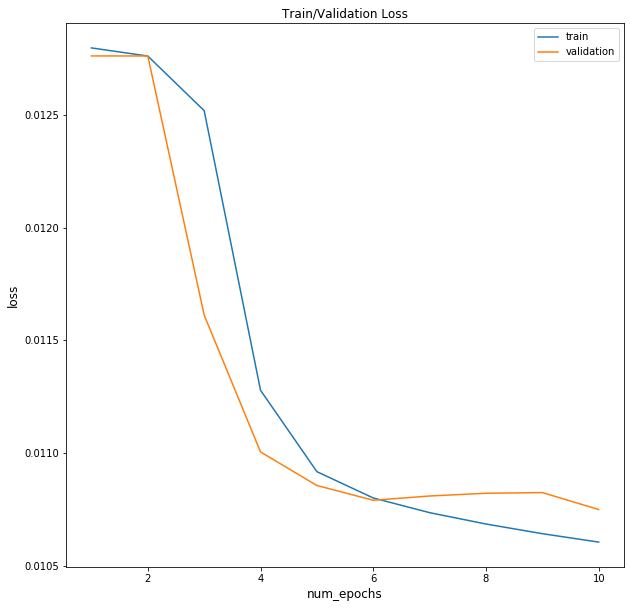

In [52]:
plot_epoch_loss(nEpoch, train_loss_lst, val_loss_lst)

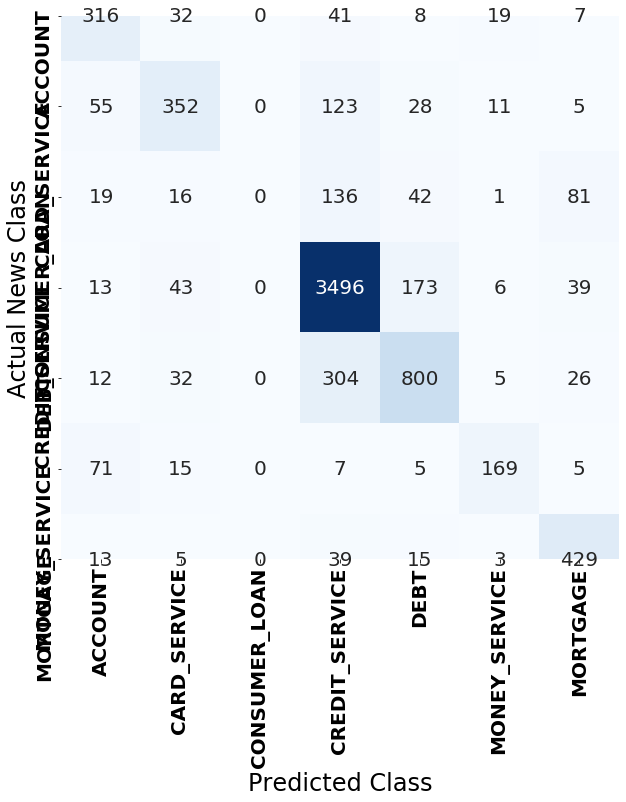

The F1 score of validation set is 0.772414601565667


In [53]:
ticklabels = pd.read_csv("data/encoding_label_dict_token.csv", names = ["name", "label"], header = 0)
ticklabels = ticklabels["name"].tolist()

plot_confusion_matrix(labels_test, val_preds, ticklabels)